In [1]:
import numpy as np
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf

In [24]:
# Function to convert ellipse parameters to coefficients
def convert_df_to_mm(df, image_width_px, image_height_px, sensor_format=1/4):
    """

    :param df:
    :param sensor_width_mm:
    :param sensor_height_mm:
    :param image_width_px:
    :param image_height_px:
    :param focal_length_mm:
    :return:
    """
    if sensor_format == 1/4:
        sensor_width_mm = 3.2
        sensor_height_mm = 2.4
    else:
        raise ValueError('sensor format not supported')

    # Calculate pixel size in millimeters
    pixel_size = sensor_width_mm / image_width_px #x/y are equivalent in this conversion

    # calculte relative displacement in mm from image center:
    df['center_x_mm'] = (df['center_x'] - image_width_px / 2) * pixel_size
    df['center_y_mm'] = (df['center_y'] - image_height_px / 2) * pixel_size

    # change axes units to mm:
    df['width_mm'] = df['width'] * pixel_size
    df['height_mm'] = df['height'] * pixel_size

    return df

def ellipse_2d_to_cone_coefficients(row, focal_length=3.7):
    """
    Convert ellipse parameters to coefficients of the cone equation as presented in safaee-rad et.al 1992

    Args:
        row (pandas.Series): A pandas Series containing ellipse parameters.
            It should have columns 'center_x', 'center_y', 'width', 'height', and 'phi'.
        focal_length (float): the focal length of the camera used
    Returns:
        pandas.Series: A pandas Series containing the coefficients of the cone equation for the algorithm
    """
    x0 = row['center_x_mm']
    y0 = row['center_y_mm']
    width = row['width_mm']
    height = row['height_mm']

    major_axis = np.max([width, height]) / 2
    min_axis = np.min([width, height]) / 2

    phi = row['phi']

    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)

    # getting a',b',g',f', h', d'. a1 is a' etc.
    a1 = (major_axis) ** 2
    b1 = (min_axis) ** 2
    g1 = (-a1 * x0 * np.cos(phi)) - (b1 * y0 * np.sin(phi)) # translation x
    f1 = (-a1 * x0 * np.sin(phi)) - (b1 * y0 * np.cos(phi)) # translation y
    h1 = (a1 - b1) * np.tan(phi) # tilt
    d = 0

    # next, we utilize equation (3) from the paper, and the corresponding supplied formulae for the cone coefficients
    # for the explicit cases where alpha=0, beta=0 and gamma = focal length of the camera used:
    a = a1 * (focal_length**2)
    b = b1 * (focal_length**2)
    c = 0
    d = 0
    f = -focal_length*(f1)
    g = -focal_length*(g1)
    h = focal_length**2 * h1
    u = focal_length**2 * g1
    v = focal_length**2 * f1
    w = 0


    return pd.Series({'a': a, 'b': b, 'c': c, 'd': d, 'f': f, 'g': g, 'h':h, 'u':u, 'v':v, 'w':w})


As a preliminary step, we choose a target block and preprocess it:

In [2]:
# this step creates block_collection - a list of BlockSync objects of interest
block_numbers = [23]
bad_blocks = [42, 61, 62, 64, 65, 66]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b
block_dict

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!


{'023': BlockSync object for animal PV_62 with 
 block_num 023 at date 2023-04-27_10-52-42}

In [3]:
# This step is used to quickly go over the analyzed blocks and load their internal data
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
getting eye brigtness values for block 023...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder


In [4]:
# This is a continuation of the previous - more data loadings
for block in block_collection:
    block.import_manual_sync_df()
    block.read_dlc_data()

eye dataframes loaded from analysis folder


In [20]:
le_df = convert_df_to_mm(block.le_df[['L_eye_frame','center_x','center_y','width','height','phi']],640,480)
re_df = convert_df_to_mm(block.re_df[['R_eye_frame','center_x','center_y','width','height','phi']],640,480)


<ipython-input-19-9d07506cdf86>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['center_x_mm'] = (df['center_x'] - image_width_px / 2) * pixel_size
<ipython-input-19-9d07506cdf86>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['center_y_mm'] = (df['center_y'] - image_height_px / 2) * pixel_size
<ipython-input-19-9d07506cdf86>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [26]:
le_cones = le_df.apply(ellipse_2d_to_cone_coefficients, axis=1)
re_cones = re_df.apply(ellipse_2d_to_cone_coefficients, axis=1)

In [133]:
def visualize_cones(dataframe):
    # Create a 3D figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Iterate over rows in the DataFrame
    for index, row in dataframe.iterrows():
        # Extract coefficients from the DataFrame row
        a, b, c, d, f, g, h, u, v, w = row

        # Create a meshgrid for x, y, and z values
        x = np.linspace(-10, 10, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)

        # Calculate the z values based on the cone equation
        Z = (-a*X**2 - b*Y**2 - 2*f*X*Y - 2*g*X - 2*h*Y - 2*u*X - 2*v*Y) / 2

        # Plot the cone surface
        ax.plot_surface(X, Y, Z, alpha=0.5)

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.show()

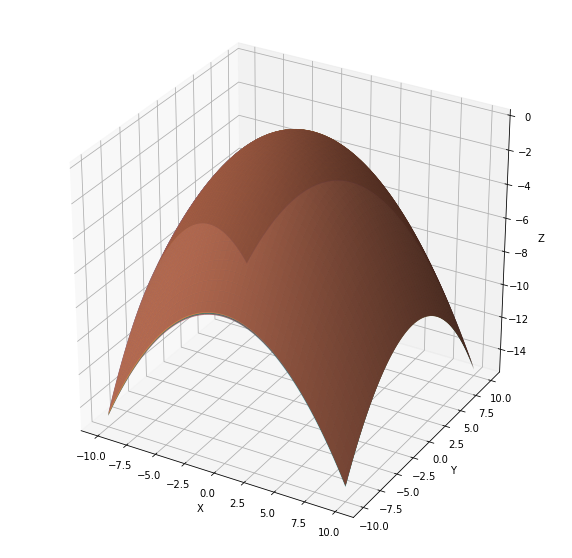

In [134]:
visualize_cones(le_cones.iloc[200:210])

In [126]:
import cmath

# right now, solves the discriminating cubic using different methods
def solve_discriminating_cubic_of_cone(cone_row):

    a = cone_row['a']
    b = cone_row['b']
    c = cone_row['c']
    d = cone_row['d']
    f = cone_row['f']
    g = cone_row['g']
    h = cone_row['h']
    u = cone_row['u']
    v = cone_row['v']
    w = cone_row['w']

    roots = []
    coef1 = 1
    coef2 = -(a + b + c)
    coef3 = b * c + c * a + a * b - f**2 - g**2 - h**2
    coef4 = -(a * b * c + 2 * f * g * h - a * f**2 - b * g**2 - c * h**2)

    roots_cardano = solve_cubic_cardano(coef1, coef2, coef3, coef4)
    roots.append(roots_cardano)

    initial_guesses = [
        [1 + 2j, 1 - 2j, -1 + 10j],
        [2 + 1j, 1 - 20j, -2 - 1j],
        [0.5 + 1j, 1 - 1j, -0.02 - 0.5j],
        [1 + 0j, 2 + 0j, -10 + 0j],
        [20 + 0j, 3 + 0j, -200 + 0j],
    ]

    for i in initial_guesses:
        roots_durand_kerner = solve_cubic_durand_kerner([coef1, coef2, coef3, coef4],i)
        roots.append(roots_durand_kerner)
    return roots

### Implementation of two different methods to find the roots of the discriminating cubic equation
# Method 1: Cardano's method
# including reducing the cubic equation to a depressed cubic and solving it using trigonometric identities.
#
# Note: not require initial guesses but not promise one negative root
def solve_cubic_cardano(a, b, c, d):
    # Convert coefficients to Cardano's form
    p = c / a - (b**2) / (3 * a**2)
    q = (2 * b**3) / (27 * a**3) - (b * c) / (3 * a**2) + d / a

    # Calculate discriminant
    discriminant = (q**2) / 4 + (p**3) / 27

    if discriminant > 0:
        # One real root and two complex roots
        u = (-(q / 2) + cmath.sqrt(discriminant))**(1/3)
        v = (-(q / 2) - cmath.sqrt(discriminant))**(1/3)
        root1 = u + v - b / (3 * a)
        root2 = -(u + v) / 2 - b / (3 * a) + (u - v) * cmath.sqrt(3) * 1j / 2
        root3 = -(u + v) / 2 - b / (3 * a) - (u - v) * cmath.sqrt(3) * 1j / 2
    elif discriminant == 0:
        # All roots are real and at least two are equal
        u = (-q / 2)**(1/3)
        root1 = 2 * u - b / (3 * a)
        root2 = -(u + b / (3 * a))
        root3 = root2
    else:
        # All roots are real and distinct
        u = ((-(q / 2) + cmath.sqrt(discriminant))**(1/3)).real
        v = ((-(q / 2) - cmath.sqrt(discriminant))**(1/3)).real
        root1 = u + v - b / (3 * a)
        root2 = -(u + v) / 2 - b / (3 * a) + (u - v) * cmath.sqrt(3) * 1j / 2
        root3 = -(u + v) / 2 - b / (3 * a) - (u - v) * cmath.sqrt(3) * 1j / 2

    return [root1, root2, root3]

# Method 2: Durand-Kerner method
# an iterative numerical technique for finding all roots of a polynomial equation simultaneously.
#
# Note: require initial guesses but the specific values of these initial guesses don't significantly affect the roots,
#       and we can use the initial guesses to get one negative root
def solve_cubic_durand_kerner(coefficients, initial_guesses, tolerance=1e-10, max_iterations=1000):
    n = len(coefficients) - 1  # Degree of the polynomial
    roots = np.array(initial_guesses, dtype=complex)


    for _ in range(max_iterations):
        new_roots = np.empty_like(roots, dtype=complex)
        for k in range(n):
            numerator = np.polyval(coefficients, roots[k])
            denominator = 1.0
            for j in range(n):
                if j != k:
                    denominator *= roots[k] - roots[j]
            new_roots[k] = roots[k] - numerator / denominator
        error = np.max(np.abs(new_roots - roots))
        if error < tolerance:
            return new_roots.tolist()
        roots = new_roots

    return None  # Max iterations reached without convergence
###

def compare_complex(a, b, tolerance=1e-6):
    """
    Compare two complex numbers a and b within a specified tolerance.

    Args:
    a (complex): First complex number.
    b (complex): Second complex number.
    tolerance (float): Tolerance for comparison.

    Returns:
    bool: True if |a - b| < tolerance, False otherwise.
    """
    return abs(a - b) < tolerance

def compare_roots(method1_roots, method2_roots, tolerance=1e-6):
    """
    Compare the roots obtained from two different root-finding methods.

    Args:
    method1_roots (list): List of roots obtained from the first method.
    method2_roots (list): List of roots obtained from the second method.
    tolerance (float): Tolerance for root comparison.

    Returns:
    bool: True if the roots are consistent within the given tolerance, False otherwise.
    """

    # Check if the number of roots matches
    if len(method1_roots) != len(method2_roots):
        return False

    # Sort the roots for consistent comparison
    method1_roots.sort(key=lambda x: abs(x))
    method2_roots.sort(key=lambda x: abs(x))

    # Compare the roots element by element within the specified tolerance
    for root1, root2 in zip(method1_roots, method2_roots):
        if not compare_complex(root1, root2, tolerance):
            return False

    # If all roots are consistent within the tolerance, return True
    return True

def is_close_to_real(root, tolerance=1e-6):
    """
    Check if a complex root is close to a real number.

    Args:
    root (complex): Complex number to check.
    tolerance (float): Tolerance for considering a root as real.

    Returns:
    bool: True if the root is close to real, False otherwise.
    """
    return abs(root.imag) < tolerance


In [117]:

cone_row = le_cones.iloc[1090]
r1, r2, r3, r4, r5, r6 = solve_discriminating_cubic_of_cone(cone_row=cone_row)
#compare_roots(r1, r2)
# r1, r2, r3, r4, r5
r1_real = [root.real for root in r1 if is_close_to_real(root)]
r2_real = [root.real for root in r2 if is_close_to_real(root)]
r3_real = [root.real for root in r3 if is_close_to_real(root)]
r4_real = [root.real for root in r4 if is_close_to_real(root)]
r5_real = [root.real for root in r5 if is_close_to_real(root)]
r6_real = [root.real for root in r6 if is_close_to_real(root)]

# visualize_roots([r1_real,r2_real, r3_real])
r1_real,r2_real, r3_real, r4_real, r5_real, r6_real

([0.1996803313016008, 0.04602062582847837, 0.04602062582847837],
 [0.19968033130160082, 0.09624842922779869, -0.004207177570841959],
 [0.09624842922779868, 0.19968033130160082, -0.004207177570841958],
 [0.09624842922779868, 0.19968033130160082, -0.004207177570841958],
 [0.19968033130160082, 0.09624842922779869, -0.004207177570841959],
 [0.19968033130160082, -0.004207177570841959, 0.09624842922779867])

In [110]:
cone_row

a    0.161641
b    0.099717
c    0.000000
d    0.000000
f    0.004806
g   -0.024102
h   -0.023018
u    0.089179
v   -0.017782
w    0.000000
Name: 1000, dtype: float64

create a function to convert ellipses format to coefficients

In [17]:

le_df = block.le_df[['L_eye_frame','center_x','center_y','width','height','phi']]
re_df = block.re_df[['R_eye_frame','center_x','center_y','width','height','phi']]

# Apply the conversion function to each row and create a new DataFrame
l_coefficients_df = le_df.apply(ellipse_to_coefficients, axis=1)
r_coefficients_df = re_df.apply(ellipse_to_coefficients, axis=1)

# Combine the 'L_eye_frame' column with the coefficients DataFrame
l_ellipses = pd.concat([le_df['L_eye_frame'], l_coefficients_df], axis=1)
r_ellipses = pd.concat([re_df['R_eye_frame'], r_coefficients_df], axis=1)

Now that I have ellipse coefficients, I need to go through the first bit of the 1992 algorithm - here is an outline of what needs to be done:

In [40]:
# first, I'll define a function to convert pixel displacement to mm-based displacement (to integrate everything around the focal length)
def pixel_to_mm(x_pixel, y_pixel, sensor_width_mm, sensor_height_mm, image_width_px, image_height_px, focal_length_mm):
    """
    Convert pixel coordinates to millimeters based on camera sensor specifications and focal length.

    Args:
        x_pixel (int): The x-coordinate in pixels.
        y_pixel (int): The y-coordinate in pixels.
        sensor_width_mm (float): The width of the camera sensor in millimeters.
        sensor_height_mm (float): The height of the camera sensor in millimeters.
        image_width_px (int): The width of the image in pixels.
        image_height_px (int): The height of the image in pixels.
        focal_length_mm (float): The focal length of the camera lens in millimeters.

    Returns:
        Tuple[float, float, float]: A tuple containing the displacement from the center (x, y) in millimeters,
        and the distance from the sensor to the object in millimeters.
    """
    # Calculate pixel size in millimeters
    pixel_size_x = sensor_width_mm / image_width_px
    pixel_size_y = sensor_height_mm / image_height_px

    # Calculate the center point of the frame in millimeters
    center_x_mm = sensor_width_mm / 2
    center_y_mm = sensor_height_mm / 2

    # Calculate the displacement from the center in millimeters
    displacement_x_mm = (x_pixel - image_width_px / 2) * pixel_size_x
    displacement_y_mm = (y_pixel - image_height_px / 2) * pixel_size_y

    # Calculate the distance from the sensor to the object using the focal length
    distance_mm = focal_length_mm

    return displacement_x_mm, displacement_y_mm, distance_mm

# and another function to convert the whole parameters of an ellipse in my format to mm:
def convert_ellipse_to_mm(center_x_px, center_y_px, width_px, height_px, phi_deg, sensor_size="1/4", frame_size=(640, 480)):
    """
    Convert pixel-based ellipse parameters to millimeters based on sensor and frame size.

    Args:
        center_x_px (int): X-coordinate of the ellipse center in pixels.
        center_y_px (int): Y-coordinate of the ellipse center in pixels.
        width_px (int): Width of the ellipse in pixels.
        height_px (int): Height of the ellipse in pixels.
        phi_deg (float): Rotation angle of the ellipse in degrees.
        sensor_size (str, optional): Size of the camera sensor (e.g., "1/4" for 1/4" sensor). Default is "1/4".
        frame_size (tuple, optional): Size of the image frame in pixels (width, height). Default is (640, 480).

    Returns:
        tuple: A tuple containing converted values in millimeters: (center_x_mm, center_y_mm, width_mm, height_mm, phi_deg).
    """
    # Calculate the focal length of the camera
    if sensor_size == "1/4":
        sensor_width_mm = 3.6  # 1/4" sensor size in mm
    else:
        raise ValueError("Unsupported sensor size")

    # Calculate the conversion factors for width and height
    width_conversion = sensor_width_mm / frame_size[0]  # mm per pixel in width
    height_conversion = sensor_width_mm / frame_size[1]  # mm per pixel in height

    # Calculate the displacement from the center in millimeters
    displacement_x_mm = (center_x_px - frame_size[0] / 2) * width_conversion
    displacement_y_mm = (center_y_px - frame_size[1] / 2) * height_conversion

    # Calculate the distance from the sensor to the object using the focal length
    focal_length_mm = sensor_width_mm / (2 * np.tan(np.deg2rad(62.2) / 2))  # Assuming a 62.2-degree horizontal field of view

    # Calculate the center point of the frame in millimeters
    center_x_mm = displacement_x_mm
    center_y_mm = displacement_y_mm

    return center_x_mm, center_y_mm, width_px * width_conversion, height_px * height_conversion, phi_deg



In [43]:
# the next function should take in ellipse data (based on the pipeline so far) + focal depth and convert them into the coefficients of a cone with its base
# situated on the 2D-image ellipse and its vertex at the sensor (with the origin defined as the image plane's middle)
def estimate_cone_coefficients_with_depth(center_x, center_y, width, height, phi, focal_length):
    """
    Estimate the coefficients of the general equation of a cone with depth based on ellipse parameters and focal length.

    Args:
        center_x (float): X-coordinate of the ellipse center.
        center_y (float): Y-coordinate of the ellipse center.
        width (float): Width of the ellipse.
        height (float): Height of the ellipse.
        phi (float): Angle of rotation of the ellipse in degrees.
        focal_length (float): Focal length of the camera lens in millimeters.

    Returns:
        Tuple[float, float, float, float, float, float, float, float, float, float]:
        A tuple containing the coefficients 'a', 'b', 'c', 'f', 'g', 'h', 'u', 'v', 'w', and 'd' of the general equation
        of the cone with depth.
    """
    # Convert phi from degrees to radians
    phi_rad = np.deg2rad(phi)

    # Extract ellipse parameters
    a_ellipse = (width / 2) ** 2
    b_ellipse = (height / 2) ** 2
    c_ellipse = 0  # Z-axis component is zero for 2D ellipse
    d_ellipse = 0  # No linear term
    f_ellipse = 0  # No cross-product term between x and y
    g_ellipse = 0  # No cross-product term between x and z
    h_ellipse = 0  # No cross-product term between y and z

    # Calculate the translations u, v, and w
    u = center_x
    v = center_y
    w = -focal_length  # Negative because the vertex is at -e along the z-axis

    # Calculate coefficients of the general equation of the cone with depth
    gamma = 1 / focal_length
    alpha = center_x
    beta = center_y

    a = gamma ** 2 * a_ellipse
    b = gamma ** 2 * b_ellipse
    c = a_ellipse * alpha ** 2 + 2 * h_ellipse * alpha * beta + b_ellipse * beta ** 2 + 2 * g_ellipse * alpha + 2 * f_ellipse * beta + d_ellipse
    d = gamma ** 2 * d_ellipse
    f = -gamma * (b_ellipse * beta + h_ellipse * alpha + f_ellipse)
    g = -gamma * (h_ellipse * beta + a_ellipse * alpha + g_ellipse)
    h = gamma ** 2 * h_ellipse
    u = gamma ** 2 * g_ellipse
    v = gamma ** 2 * f_ellipse
    w = -gamma * (f_ellipse * beta + g_ellipse * alpha + d_ellipse)

    return a, b, c, f, g, h, u, v, w, d

In [45]:
# trial section:
# let's take an example ellipse and run it through the pipe so far:

trial_ellipse = le_df.iloc[0].drop('L_eye_frame')
el_x, el_y, el_width, el_height, el_phi = convert_ellipse_to_mm(trial_ellipse['center_x'], trial_ellipse['center_y'],trial_ellipse['width'],trial_ellipse['height'],trial_ellipse['phi'])
cone_a, cone_b, cone_c, cone_f, cone_g, cone_h, cone_u, cone_v, cone_w, cone_d = estimate_cone_coefficients_with_depth(el_x,el_y,el_width,el_height,el_phi,3.7)


In [51]:
import numpy as np
from scipy.optimize import root_scalar

def solve_discriminating_cubic(a, b, c, f, g, h):
    """
    Solve the discriminating cubic equation to find positive "lambda" values.

    Args:
        a (float): Coefficient 'a' of the general equation of the cone.
        b (float): Coefficient 'b' of the general equation of the cone.
        c (float): Coefficient 'c' of the general equation of the cone.
        f (float): Coefficient 'f' of the general equation of the cone.
        g (float): Coefficient 'g' of the general equation of the cone.
        h (float): Coefficient 'h' of the general equation of the cone.

    Returns:
        list: A list containing positive "lambda" values ["lambda"_1, "lambda"_2, "lambda"_3].

    Raises:
        ValueError: If valid "lambda" values cannot be found.

    This function solves the discriminating cubic equation (10) to find positive "lambda" values "lambda"_1, "lambda"_2, and "lambda"_3,
    ensuring that "lambda"_1 and "lambda"_2 are positive. The equation is solved using the `root_scalar` method from SciPy.
    If valid "lambda" values cannot be found, a ValueError is raised.
    """
    # Define the coefficients of the discriminating cubic equation (10)
    def cubic_equation(lmbda):
        return (
            lmbda ** 3 - lmbda ** 2 * (a + b + c) + lmbda * (b * c + c * a + a * b - f ** 2 - g ** 2 - h ** 2)
            - (a * b * c + 2 * f * g * h - a * f ** 2 - b * g ** 2 - c * h ** 2)
        )

    # Solve the cubic equation to find lambdas
    roots = np.roots([1, -(a + b + c), (b * c + c * a + a * b - f ** 2 - g ** 2 - h ** 2), -(a * b * c + 2 * f * g * h - a * f ** 2 - b * g ** 2 - c * h ** 2)])

    # Filter positive roots
    positive_roots = [root for root in roots if root > 0]

    if len(positive_roots) >= 2:
        positive_roots.sort()
        return positive_roots
    else:
        raise ValueError("Failed to find valid lambdas with positive values.")

# Example usage:
a, b, c, f, g, h = 0.2, 0.3, 0.1, 0.05, 0.1, 0.03
lambdas = solve_discriminating_cubic(a, b, c, f, g, h)
print("Lambda values:", lambdas)



Lambda values: [0.03536362768494998, 0.22690024065965203, 0.33773613165539784]


In [53]:
# 2nd iteration with gpt:
import numpy as np
from scipy.optimize import root_scalar

def solve_discriminating_cubic(a, b, c, f, g, h):
    """
    Solve the discriminating cubic equation to find lambda values.

    Args:
        a, b, c, f, g, h (float): Coefficients from Equation 7.

    Returns:
        dict: Dictionary containing lambda values labeled as 'lambda1', 'lambda2', 'lambda3'.
    """
    # Define the coefficients of the discriminating cubic equation (Equation 10)
    def cubic_equation(lmbda):
        l1, l2, l3 = lmbda[0], lmbda[1], lmbda[2]
        return [
            l1 * l2 * l3 - l1 - l2 - l3,
            l1 * l2 + l1 * l3 + l2 * l3 - (a + b + c),
            l1 + l2 + l3 - (a * b * c + f * f + g * g + h * h),
            l1 * l2 * l3 - (a * b * c + 2 * f * g * h)
        ]

    # Solve the cubic equation to find lambdas
    root = root_scalar(cubic_equation, bracket=[0, 1], method='bisect')

    if root.converged:
        lmbda = [root.root, 1, 1 / root.root]
        lambda_dict = {
            'lambda1': lmbda[0],
            'lambda2': lmbda[1],
            'lambda3': lmbda[2]
        }
        return lambda_dict
    else:
        raise ValueError("Failed to find valid lambdas")

def calculate_transformation_matrix(lambdas):
    """
    Calculate the rotational transformation matrix T1.

    Args:
        lambdas (dict): Dictionary containing lambda1, lambda2, and lambda3.

    Returns:
        numpy.ndarray: Rotational transformation matrix T1.
    """
    lambda1, lambda2, lambda3 = lambdas['lambda1'], lambdas['lambda2'], lambdas['lambda3']

    # Calculate elements of T1
    t1 = (b - lambda1) * g - f * h
    t2 = (a - lambda1) * f - g * h
    t3 = -(a - lambda1) * (t1 / t2) / ((g - h) / g)

    m1 = 1 / np.sqrt(1 + (t1 / t2) ** 2 + t3 ** 2)
    l1 = (t1 / t2) * m1
    n1 = t3 * m1

    m2 = 1
    l2 = 0
    n2 = 0

    m3 = t3 * m1
    l3 = (t1 / t2) * m1
    n3 = m1

    # Build T1 matrix
    T1 = np.array([[l1, m1, n1, 0],
                   [l2, m2, n2, 0],
                   [l3, m3, n3, 0],
                   [0, 0, 0, 1]])

    return T1

def reduce_to_canonical_form(a, b, c, f, g, h):
    """
    Reduce the general equation of conicoids to canonical form.

    Args:
        a, b, c, f, g, h (float): Coefficients from Equation 7.

    Returns:
        tuple: Tuple containing the rotational transformation matrix T1.
    """
    # Step 1: Solve the discriminating cubic equation
    lambdas = solve_discriminating_cubic(a, b, c, f, g, h)

    # Step 2: Calculate the rotational transformation matrix T1
    T1 = calculate_transformation_matrix(lambdas)

    return T1

# Example usage:
a, b, c, f, g, h = 0.2, 0.3, 0.1, 0.05, 0.1, 0.03
T1 = reduce_to_canonical_form(a, b, c, f, g, h)
print("Rotational Transformation Matrix T1:")
print(T1)


TypeError: 'float' object is not subscriptable

In [ ]:
import math

def compute_surface_normal(coefficients_of_ellipse, effective_focal_length):
    # Step 1: Estimation of coefficients of the general equation of the cone
    a, b, c, f, g, h, u, v, w, d = estimate_cone_coefficients(coefficients_of_ellipse, effective_focal_length)

    # Step 2: Reduction of the equation of the cone
    lambda_1, lambda_2, lambda_3 = solve_discriminating_cubic(a, b, c, f, g, h)

    # Step 3: Estimation of coefficients of the equation of the circular-feature plane
    if lambda_1 < lambda_2:
        l, m, n = equation_30(lambda_1, lambda_2, lambda_3)
    elif lambda_1 > lambda_2:
        l, m, n = equation_31(lambda_1, lambda_2, lambda_3)
    else:
        l, m, n = equation_33()

    return l, m, n

import numpy as np
from scipy.optimize import fsolve



def solve_discriminating_cubic(a, b, c, f, g, h):
    # Implement your logic here to solve the discriminating cubic equation (Equation 10)
    # and obtain the roots lambda_1, lambda_2, and lambda_3
    # ...
    return lambda_1, lambda_2, lambda_3

def equation_30(lambda_1, lambda_2, lambda_3):
    n = math.sqrt((lambda_1 - lambda_3) / (lambda_2 - lambda_3))
    m = math.sqrt((lambda_2 - lambda_1) / (lambda_2 - lambda_3))
    l = 0
    return l, m, n

def equation_31(lambda_1, lambda_2, lambda_3):
    n = math.sqrt((lambda_2 - lambda_3) / (lambda_1 - lambda_3))
    m = 0
    l = math.sqrt((lambda_1 - lambda_2) / (lambda_1 - lambda_3))
    return l, m, n

def equation_33():
    n = 1
    m = 0
    l = 0
    return l, m, n


In [ ]:
import numpy as np
from scipy.optimize import fsolve

def estimate_cone_coefficients(center_x, center_y, width, height, phi, focal_length):
    # Convert phi from degrees to radians
    phi_rad = np.deg2rad(phi)

    # Extract ellipse parameters
    a_ellipse = (width / 2) ** 2
    b_ellipse = (height / 2) ** 2
    c_ellipse = 0  # Z-axis component is zero for 2D ellipse
    d_ellipse = 0  # No linear term
    f_ellipse = 0  # No cross-product term between x and y
    g_ellipse = 0  # No cross-product term between x and z
    h_ellipse = 0  # No cross-product term between y and z

    # Create a function to solve for lambda_1, lambda_2, and lambda_3
    def cubic_equation(vars):
        lambda_1, lambda_2, lambda_3 = vars
        return [
            lambda_1 - lambda_1 * (a_ellipse + b_ellipse + c_ellipse) + (b_ellipse * c_ellipse + c_ellipse * a_ellipse + a_ellipse * b_ellipse - f_ellipse**2 - g_ellipse**2 - h_ellipse**2) * lambda_1 - (a_ellipse * b_ellipse * c_ellipse + 2 * f_ellipse * g_ellipse * h_ellipse - a_ellipse * f_ellipse**2 - b_ellipse * g_ellipse**2 - c_ellipse * h_ellipse**2),
            lambda_2 - lambda_2 * (a_ellipse + b_ellipse + c_ellipse) + (b_ellipse * c_ellipse + c_ellipse * a_ellipse + a_ellipse * b_ellipse - f_ellipse**2 - g_ellipse**2 - h_ellipse**2) * lambda_2 - (a_ellipse * b_ellipse * c_ellipse + 2 * f_ellipse * g_ellipse * h_ellipse - a_ellipse * f_ellipse**2 - b_ellipse * g_ellipse**2 - c_ellipse * h_ellipse**2),
            lambda_3 - lambda_3 * (a_ellipse + b_ellipse + c_ellipse) + (b_ellipse * c_ellipse + c_ellipse * a_ellipse + a_ellipse * b_ellipse - f_ellipse**2 - g_ellipse**2 - h_ellipse**2) * lambda_3 - (a_ellipse * b_ellipse * c_ellipse + 2 * f_ellipse * g_ellipse * h_ellipse - a_ellipse * f_ellipse**2 - b_ellipse * g_ellipse**2 - c_ellipse * h_ellipse**2)
        ]

    # Solve the cubic equation to find lambda_1, lambda_2, and lambda_3
    lambdas = fsolve(cubic_equation, [1.0, 1.0, 1.0])

    # Extract the solved lambdas
    lambda_1, lambda_2, lambda_3 = lambdas

    # Calculate coefficients of the general equation of the cone
    a = lambda_1 * (focal_length ** 2)
    b = lambda_2 * (focal_length ** 2)
    c = lambda_3 * (focal_length ** 2)

    # Calculate cross-product terms (f, g, h)
    f = lambda_3 * (b_ellipse * np.sin(phi_rad))
    g = -lambda_3 * (a_ellipse * np.cos(phi_rad))
    h = lambda_3 * (a_ellipse * b_ellipse - lambda_2 * (b_ellipse * np.sin(phi_rad) - a_ellipse * np.cos(phi_rad)))

    # Constant term (d) is set to zero for vertex on the image plane
    d = 0

    return a, b, c, f, g, h, d


In [19]:
from pdf2image import convert_from_path

pdf_path = 'D:\MarkS3\Documents\Research_Papers\Three-dimensional_location_estimation_of_circular_features_for_machine_vision.pdf'
images = convert_from_path(pdf_path,poppler_path=r'C:\poppler_get_rid_of_later\poppler-23.08.0\Library\bin')

In [23]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
# Loop through each image and extract text
for i, image in enumerate(images):
    text = pytesseract.image_to_string(image)

    # Optionally, you can save the extracted text to a text file
    with open(rf'C:\poppler_get_rid_of_later\outputs\output_page_{i}.txt', 'w', encoding='utf-8') as file:
        file.write(text)